# Ninjacart Multiclass Image Classification

### Classify Images as: Tomato, Potato, Onion, or Noise (Indian Market)

## Problem Overview

Ninjacart — India’s largest fresh produce supply chain — aims to automate its vegetable sorting process using computer vision.
Our task is to build a multiclass image classifier that can correctly identify the vegetable in an image or mark it as noise.

## Import Libraries

In [2]:
import os
import json
import gdown
import random
import zipfile
import datetime
import warnings

# Core libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Deep Learning Libraries
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenetv2_preprocess


In [3]:
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

## Dataset Setup

In [4]:
url = 'https://drive.google.com/file/d/1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT/view?usp=sharing'
download_url = f'https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT'

gdown.download(download_url, 'ninjacart_dataset.zip', quiet=False)

# Extract the dataset
with zipfile.ZipFile('ninjacart_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

Downloading...
From (original): https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT
From (redirected): https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT&confirm=t&uuid=5f4aebb5-ff85-44a1-86c6-1542289fe2e8
To: /content/ninjacart_dataset.zip
100%|██████████| 275M/275M [00:03<00:00, 82.5MB/s]


In [5]:
# Define dataset paths
train_dir = '/content/ninjacart_data/train'
test_dir = '/content/ninjacart_data/test'

# List subdirectories to confirm class names
print("Train classes:", os.listdir(train_dir))
print("Test classes:", os.listdir(test_dir))

Train classes: ['onion', 'tomato', 'indian market', 'potato']
Test classes: ['onion', 'tomato', 'indian market', 'potato']


# Exploratory Data Analysis (EDA)

### Count of Images per Class

In [6]:
# Function to get image paths and labels
def get_image_paths_and_labels(directory):
    image_paths = []
    labels = []
    classes = os.listdir(directory)

    for class_name in classes:
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            for image_name in os.listdir(class_path):
                if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(class_path, image_name))
                    labels.append(class_name)

    return image_paths, labels, classes

# Get training data info
train_paths, train_labels, class_names = get_image_paths_and_labels(train_dir)
test_paths, test_labels, _ = get_image_paths_and_labels(test_dir)

print(f"Total training images: {len(train_paths)}")
print(f"Total test images: {len(test_paths)}")
print(f"Classes: {class_names}")

Total training images: 3135
Total test images: 351
Classes: ['onion', 'tomato', 'indian market', 'potato']


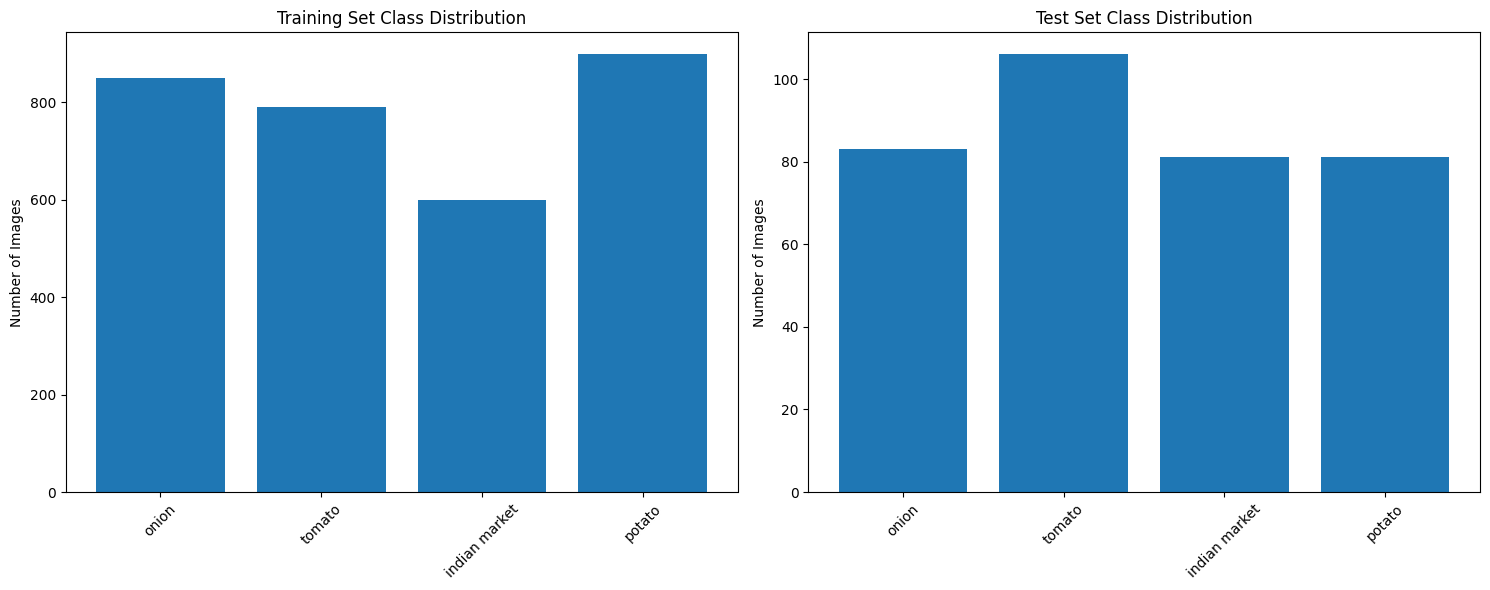

In [7]:
# Class distribution analysis
train_label_counts = Counter(train_labels)
test_label_counts = Counter(test_labels)

# Plot class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Training set distribution
ax1.bar(train_label_counts.keys(), train_label_counts.values())
ax1.set_title('Training Set Class Distribution')
ax1.set_ylabel('Number of Images')
ax1.tick_params(axis='x', rotation=45)

# Test set distribution
ax2.bar(test_label_counts.keys(), test_label_counts.values())
ax2.set_title('Test Set Class Distribution')
ax2.set_ylabel('Number of Images')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [8]:
print("\nTraining set distribution:")
for class_name, count in train_label_counts.items():
    print(f"{class_name}: {count}")

print("\nTest set distribution:")
for class_name, count in test_label_counts.items():
    print(f"{class_name}: {count}")



Training set distribution:
onion: 849
tomato: 789
indian market: 599
potato: 898

Test set distribution:
onion: 83
tomato: 106
indian market: 81
potato: 81


### Visualize Sample Images

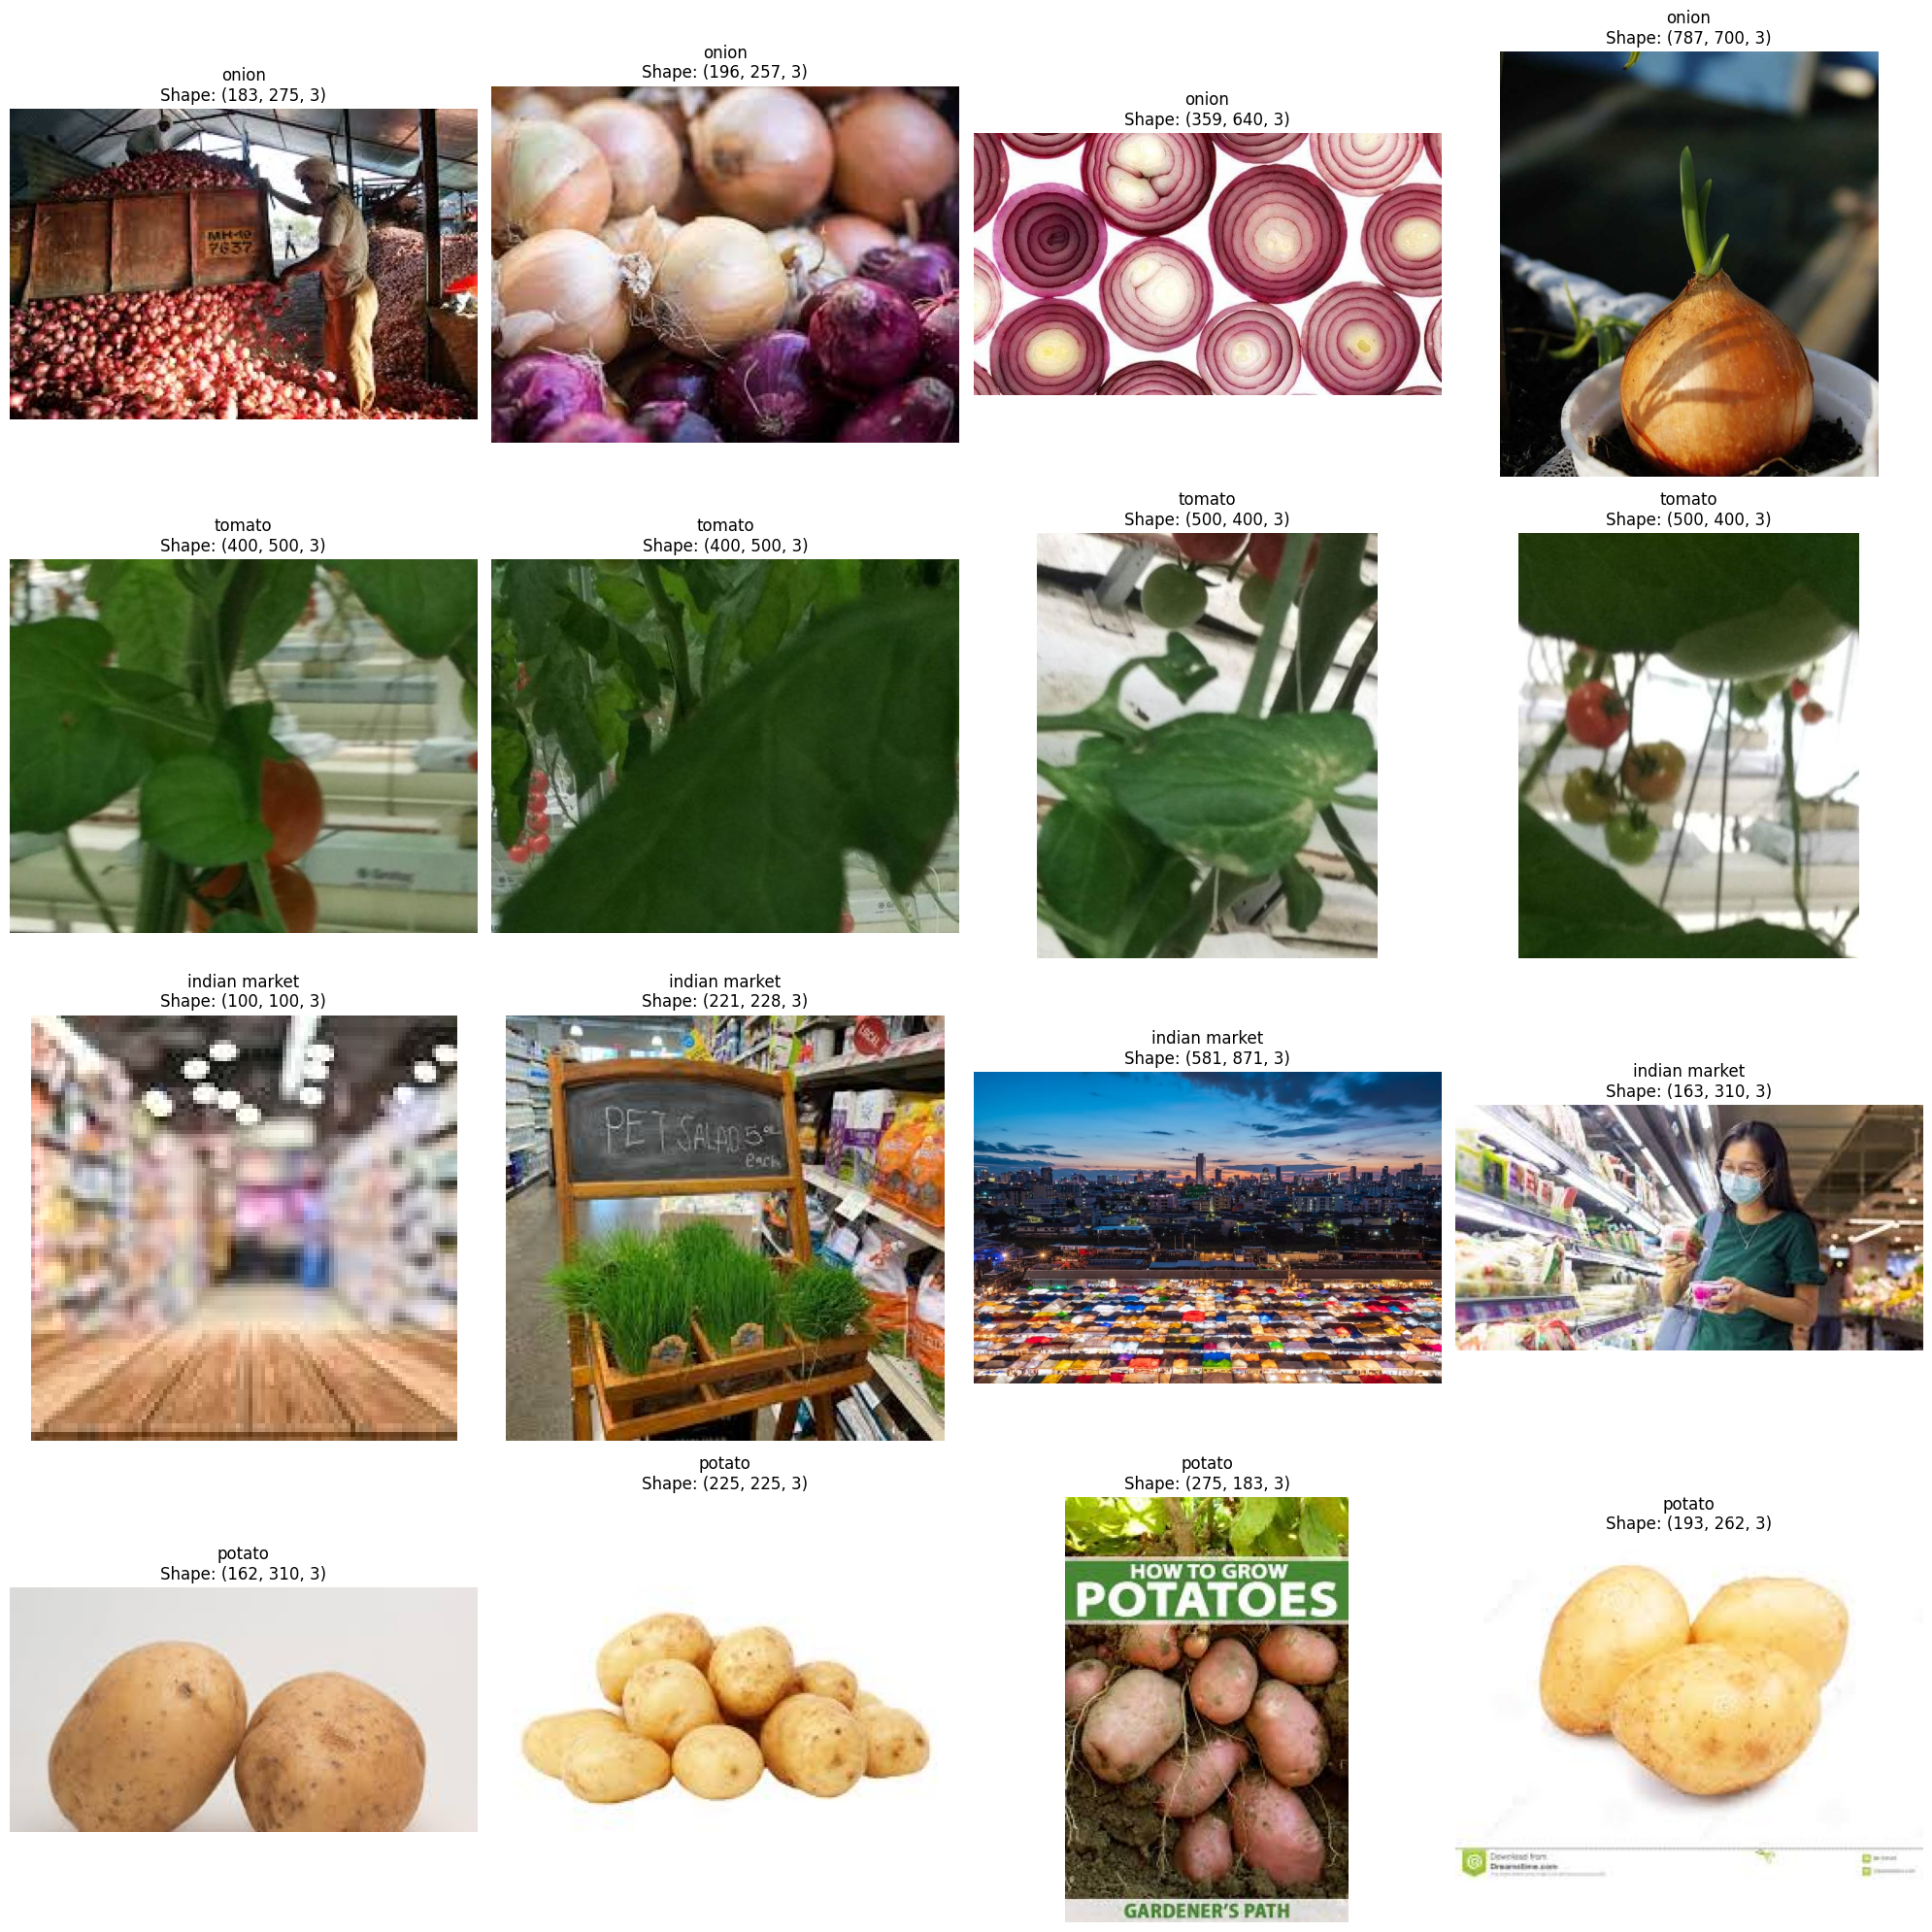

In [9]:
# Visualize sample images from each class
def plot_sample_images(image_paths, labels, class_names, samples_per_class=4):
    fig, axes = plt.subplots(len(class_names), samples_per_class, figsize=(20, 5*len(class_names)))

    for i, class_name in enumerate(class_names):
        class_images = [path for path, label in zip(image_paths, labels) if label == class_name]
        sample_images = random.sample(class_images, min(samples_per_class, len(class_images)))

        for j, img_path in enumerate(sample_images):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            axes[i][j].imshow(img)
            axes[i][j].set_title(f"{class_name}\nShape: {img.shape}")
            axes[i][j].axis('off')

    plt.tight_layout()
    plt.show()

plot_sample_images(train_paths, train_labels, class_names)

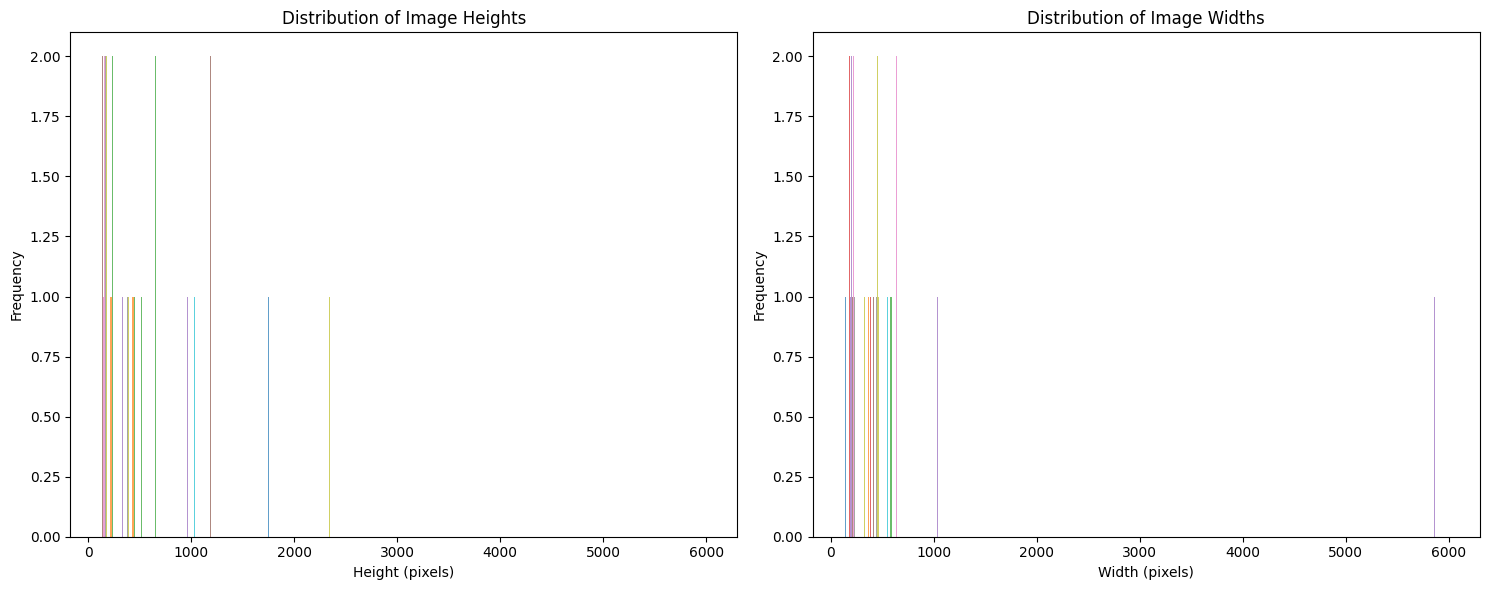

Height - Min: (100, 100), Max: (4020, 6030), Mean: 423.1
Width - Min: (100, 100), Max: (4020, 6030), Mean: 423.1


In [10]:
# Analyze image dimensions
def analyze_image_dimensions(image_paths):
    dimensions = []
    for path in image_paths[:500]:  # Sample first 500 images for efficiency
        img = cv2.imread(path)
        if img is not None:
            dimensions.append(img.shape[:2])  # (height, width)

    heights = [dim for dim in dimensions]
    widths = [dim for dim in dimensions]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    ax1.hist(heights, bins=30, alpha=0.7)
    ax1.set_title('Distribution of Image Heights')
    ax1.set_xlabel('Height (pixels)')
    ax1.set_ylabel('Frequency')

    ax2.hist(widths, bins=30, alpha=0.7)
    ax2.set_title('Distribution of Image Widths')
    ax2.set_xlabel('Width (pixels)')
    ax2.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    print(f"Height - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.1f}")
    print(f"Width - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.1f}")

analyze_image_dimensions(train_paths)

# Data Preprocessing

In [11]:
# Data preprocessing parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
RANDOM_STATE = 42
VALIDATION_SPLIT = 0.2
EPOCHS_BASE = 25
EPOCHS_TL = 25
FINE_TUNE_EPOCHS = 10           # additional epochs for fine-tuning (set 0 to disable)
FINE_TUNE_LR = 1e-5
BASE_LR = 1e-3                   # for baseline CNN
TL_LR = 1e-3

In [12]:
common_kwargs = dict(
    labels='inferred',
    label_mode='int',            # use sparse labels end-to-end
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
)

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    validation_split=VALIDATION_SPLIT,
    subset='training',
    **common_kwargs
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    validation_split=VALIDATION_SPLIT,
    subset='validation',
    **common_kwargs
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    shuffle=False,               # deterministic evaluation
    **common_kwargs
)

class_names = train_ds.class_names
num_classes = len(class_names)

# Save class mapping for reproducibility
os.makedirs("artifacts", exist_ok=True)
with open("artifacts/class_names.json", "w") as f:
    json.dump(class_names, f, indent=2)

Found 3135 files belonging to 4 classes.
Using 2508 files for training.
Found 3135 files belonging to 4 classes.
Using 627 files for validation.
Found 351 files belonging to 4 classes.


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

def configure(ds, cache=True, shuffle=False):
    if cache:
        ds = ds.cache()
    if shuffle:
        ds = ds.shuffle(1000, seed=RANDOM_STATE)
    ds = ds.prefetch(AUTOTUNE)
    return ds

train_ds = configure(train_ds, cache=True, shuffle=True)
val_ds = configure(val_ds, cache=True, shuffle=False)
test_ds = configure(test_ds, cache=True, shuffle=False)

In [14]:
# For baseline CNN: rescale + augment inside the model
rescale_layer = layers.Rescaling(1./255)

# Lightweight, GPU-accelerated augmentations
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="data_augmentation")


### Image Rescaling and Data Augmentation

In [15]:
# Create data generators with preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create training and validation generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Get class indices
class_indices = train_generator.class_indices
num_classes = len(class_indices)

print(f"Class indices: {class_indices}")
print(f"Number of classes: {num_classes}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

Found 2511 images belonging to 4 classes.
Found 624 images belonging to 4 classes.
Found 351 images belonging to 4 classes.
Class indices: {'indian market': 0, 'onion': 1, 'potato': 2, 'tomato': 3}
Number of classes: 4
Training samples: 2511
Validation samples: 624
Test samples: 351


In [16]:
log_root = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

def get_callbacks(model_name):
    os.makedirs("checkpoints", exist_ok=True)
    return [
        EarlyStopping(monitor='val_loss', patience=8, verbose=1, restore_best_weights=True),
        ModelCheckpoint(
            filepath=os.path.join("checkpoints", f'best_{model_name}.keras'),
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        TensorBoard(log_dir=os.path.join(log_root, model_name))
    ]

In [17]:
def plot_history(history, model_name):
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name} - Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name} - Loss')
    plt.tight_layout()
    plt.show()


# Baseline CNN Model

Model: "baseline_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,785,540 (98.36 MB)

 Trainable params: 25,785,092 (98.36 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.5375 - loss: 34.8832
Epoch 1: val_accuracy improved from -inf to 0.52632, saving model to checkpoints/best_baseline_cnn.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 29s 184ms/step - accuracy: 0.5386 - loss: 34.6307 - val_accuracy: 0.5263 - val_loss: 1.0416
Epoch 2/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7170 - loss: 0.7594
Epoch 2: val_accuracy did not improve from 0.52632
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 0.7168 - loss: 0.7595 - val_accuracy: 0.5136 - val_loss: 1.4154
Epoch 3/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7394 - loss: 0.7336
Epoch 3: val_accuracy did not improve from 0.52632
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 0.7394 - loss: 0.7337 - val_accuracy: 0.5167 - val_loss: 1.3993
Epoch 4/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.7264 - loss: 0.7052
Epoch 4: val_accuracy improved from 0.52632 to 0.56459, saving model to checkpoints/best_base

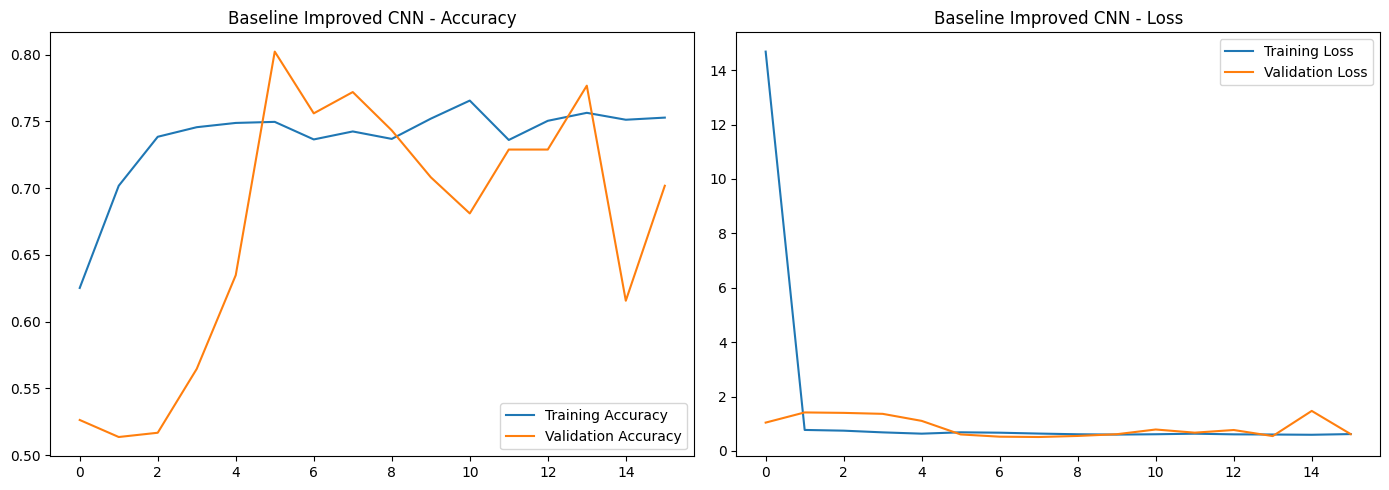

In [19]:
def create_cnn(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=num_classes):
    return keras.Sequential([
        layers.Input(shape=input_shape),
        data_augmentation,
        rescale_layer,

        layers.Conv2D(32, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(),

        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(),

        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ], name="baseline_cnn")

baseline_cnn = create_cnn()
baseline_cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=BASE_LR),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
baseline_cnn.summary()

history_baseline = baseline_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_BASE,
    callbacks=get_callbacks('baseline_cnn'),
    verbose=1
)

pd.DataFrame(history_baseline.history).to_csv('artifacts/baseline_cnn_history.csv', index=False)
plot_history(history_baseline, "Baseline Improved CNN")


# Transfer Learning Models

In [20]:
def build_transfer_model(
    base_model_name: str,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    num_classes=num_classes,
    frozen=True
):
    # Select base and preprocess
    if base_model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
        preprocess = vgg16_preprocess
    elif base_model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
        preprocess = resnet50_preprocess
    elif base_model_name == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
        preprocess = mobilenetv2_preprocess
    else:
        raise ValueError(f"Unsupported base_model_name: {base_model_name}")

    base_model.trainable = not frozen

    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    # Important: preprocess before feeding to base model
    x = layers.Lambda(preprocess, name=f"{base_model_name.lower()}_preprocess")(x)
    x = base_model(x, training=False)  # ensure BN layers run in inference mode when frozen
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs, name=f"{base_model_name.lower()}_head")
    return model, base_model

def fine_tune_top_layers(base_model, trainable_ratio=0.2):
    # Unfreeze top portion of the base model for fine-tuning
    total = len(base_model.layers)
    unfreeze_from = int(total * (1 - trainable_ratio))
    for i, layer in enumerate(base_model.layers):
        layer.trainable = (i >= unfreeze_from)


--- Training Model: Transfer Learning with VGG16 (frozen base) ---
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16_head"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16_preprocess (Lambda)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,850,116 (56.65 MB)

 Trainable params: 133,892 (523.02 KB)

 Non-trainable params: 14,716,224 (56.14 MB)

Epoch 1/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7085 - loss: 0.8278
Epoch 1: val_accuracy improved from -inf to 0.92026, saving model to checkpoints/best_vgg16_frozen.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 220ms/step - accuracy: 0.7099 - loss: 0.8240 - val_accuracy: 0.9203 - val_loss: 0.2446
Epoch 2/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8886 - loss: 0.3102
Epoch 2: val_accuracy improved from 0.92026 to 0.92504, saving model to checkpoints/best_vgg16_frozen.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - accuracy: 0.8887 - loss: 0.3098 - val_accuracy: 0.9250 - val_loss: 0.2003
Epoch 3/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9231 - loss: 0.2152
Epoch 3: val_accuracy improved from 0.92504 to 0.92982, saving model to checkpoints/best_vgg16_frozen.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - accuracy: 0.9231 - loss: 0.2153 - val_accuracy: 0.9298 - val_loss: 0.1729
Epoch 4/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9

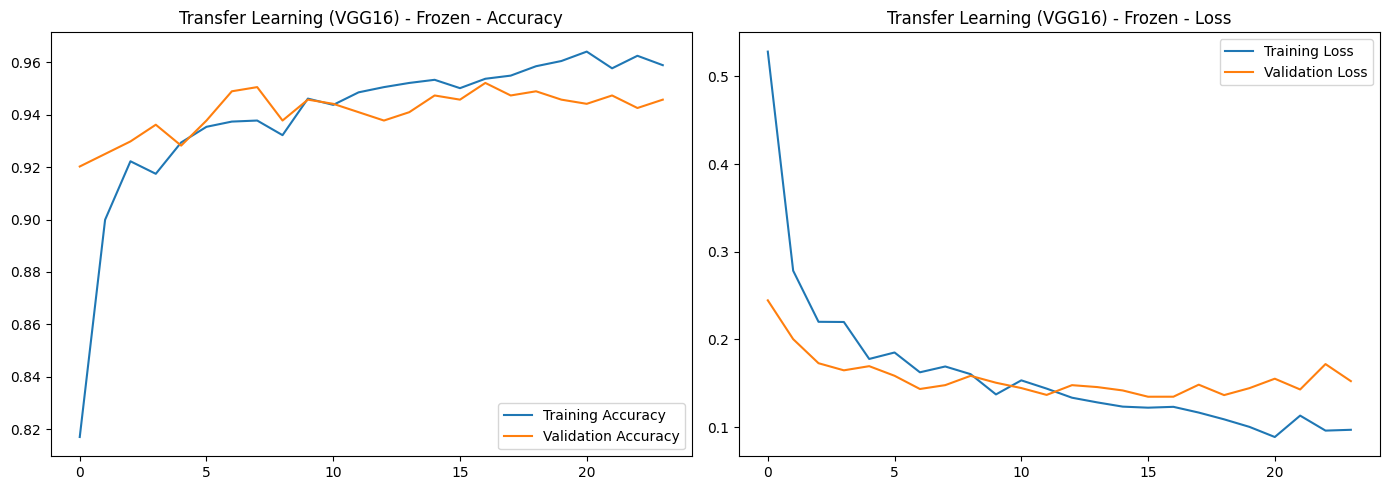


--- Fine-tuning top layers of VGG16 ---
Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9633 - loss: 0.0900
Epoch 1: val_accuracy improved from -inf to 0.95056, saving model to checkpoints/best_vgg16_finetune.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 201ms/step - accuracy: 0.9634 - loss: 0.0900 - val_accuracy: 0.9506 - val_loss: 0.1274
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9659 - loss: 0.0775
Epoch 2: val_accuracy improved from 0.95056 to 0.95375, saving model to checkpoints/best_vgg16_finetune.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 197ms/step - accuracy: 0.9660 - loss: 0.0775 - val_accuracy: 0.9537 - val_loss: 0.1328
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9716 - loss: 0.0742
Epoch 3: val_accuracy did not improve from 0.95375
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 190ms/step - accuracy: 0.9716 - loss: 0.0742 - val_accuracy: 0.9537 - val_loss: 0.1180
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9754 - loss: 

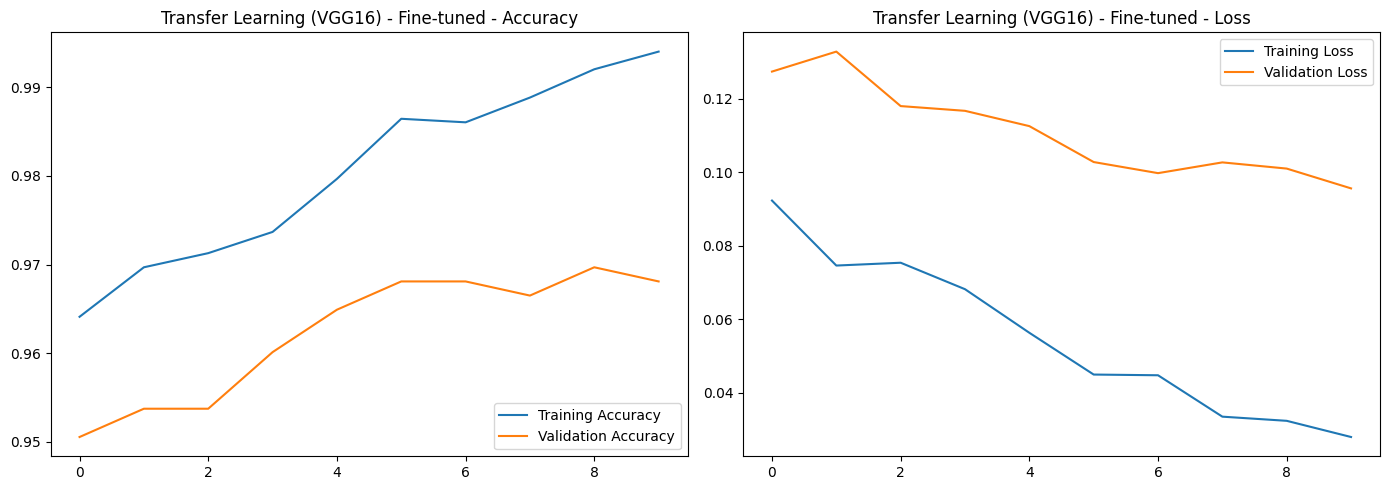


--- Training Model: Transfer Learning with ResNet50 (frozen base) ---
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "resnet50_head"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50_preprocess (Lambda)    │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,122,500 (92.02 MB)

 Trainable params: 530,180 (2.02 MB)

 Non-trainable params: 23,592,320 (90.00 MB)

Epoch 1/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.7895 - loss: 0.6204
Epoch 1: val_accuracy improved from -inf to 0.94896, saving model to checkpoints/best_resnet50_frozen.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 220ms/step - accuracy: 0.7907 - loss: 0.6169 - val_accuracy: 0.9490 - val_loss: 0.1527
Epoch 2/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9546 - loss: 0.1237
Epoch 2: val_accuracy improved from 0.94896 to 0.95853, saving model to checkpoints/best_resnet50_frozen.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 173ms/step - accuracy: 0.9546 - loss: 0.1239 - val_accuracy: 0.9585 - val_loss: 0.1112
Epoch 3/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9624 - loss: 0.0977
Epoch 3: val_accuracy improved from 0.95853 to 0.96970, saving model to checkpoints/best_resnet50_frozen.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 172ms/step - accuracy: 0.9623 - loss: 0.0978 - val_accuracy: 0.9697 - val_loss: 0.0962
Epoch 4/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accu

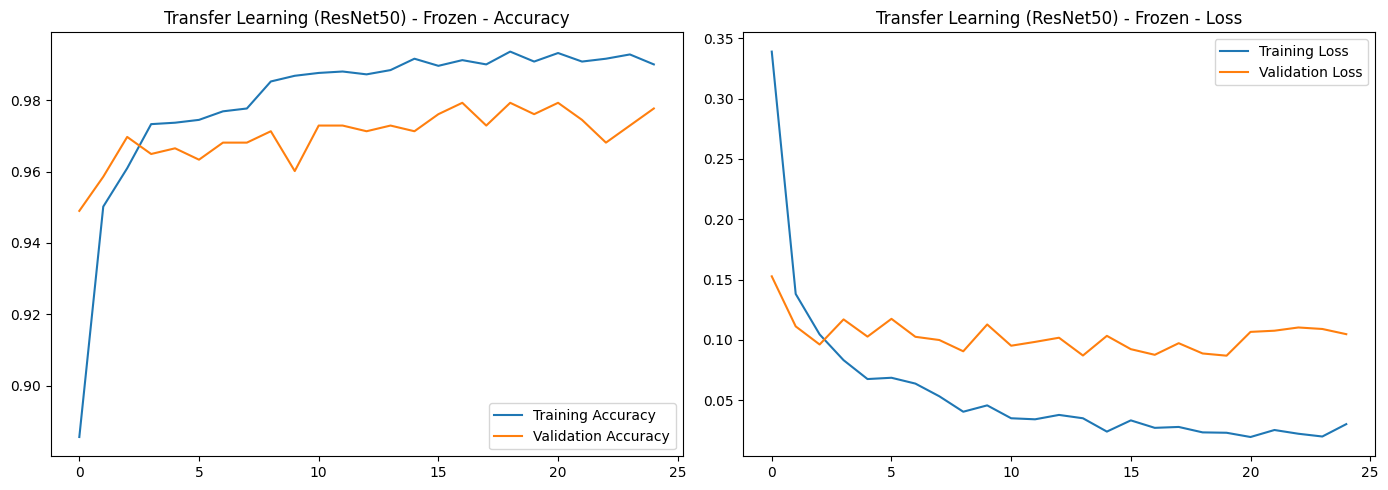


--- Fine-tuning top layers of ResNet50 ---
Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9840 - loss: 0.0415
Epoch 1: val_accuracy improved from -inf to 0.97448, saving model to checkpoints/best_resnet50_finetune.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 269ms/step - accuracy: 0.9840 - loss: 0.0415 - val_accuracy: 0.9745 - val_loss: 0.0901
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.9863 - loss: 0.0331
Epoch 2: val_accuracy improved from 0.97448 to 0.97927, saving model to checkpoints/best_resnet50_finetune.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 241ms/step - accuracy: 0.9863 - loss: 0.0330 - val_accuracy: 0.9793 - val_loss: 0.0875
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9914 - loss: 0.0280
Epoch 3: val_accuracy did not improve from 0.97927
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 217ms/step - accuracy: 0.9914 - loss: 0.0279 - val_accuracy: 0.9793 - val_loss: 0.0872
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9898

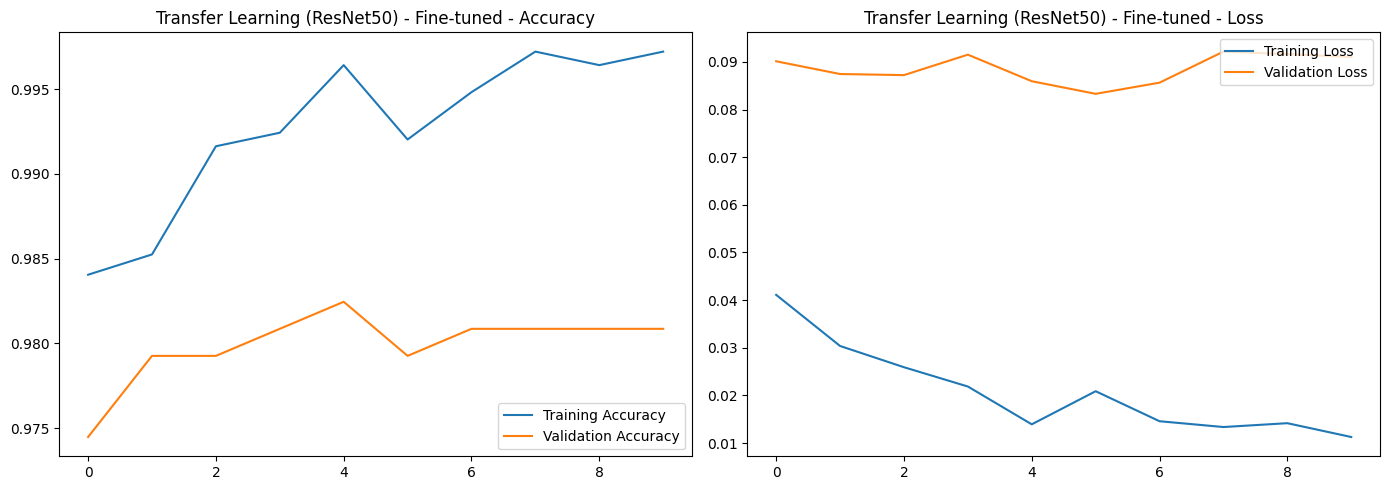


--- Training Model: Transfer Learning with MobileNetV2 (frozen base) ---
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_head"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_preprocess (Lambda) │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,593,092 (9.89 MB)

 Trainable params: 332,036 (1.27 MB)

 Non-trainable params: 2,261,056 (8.63 MB)

Epoch 1/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7821 - loss: 0.6378
Epoch 1: val_accuracy improved from -inf to 0.95694, saving model to checkpoints/best_mobilenetv2_frozen.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 106ms/step - accuracy: 0.7833 - loss: 0.6344 - val_accuracy: 0.9569 - val_loss: 0.1393
Epoch 2/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9498 - loss: 0.1322
Epoch 2: val_accuracy did not improve from 0.95694
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.9497 - loss: 0.1323 - val_accuracy: 0.9569 - val_loss: 0.1362
Epoch 3/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9474 - loss: 0.1436
Epoch 3: val_accuracy did not improve from 0.95694
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.9474 - loss: 0.1437 - val_accuracy: 0.9490 - val_loss: 0.1586
Epoch 4/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9642 - loss: 0.0957
Epoch 4: val_accuracy did not improve from 0.95694
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accu

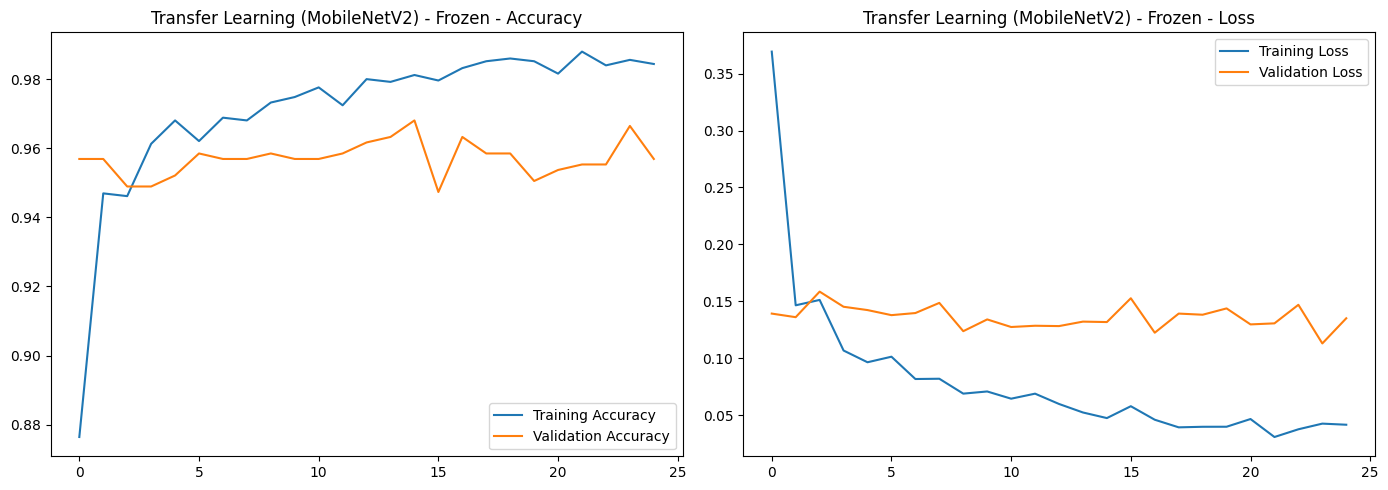


--- Fine-tuning top layers of MobileNetV2 ---
Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9560 - loss: 0.1343
Epoch 1: val_accuracy improved from -inf to 0.97129, saving model to checkpoints/best_mobilenetv2_finetune.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.9560 - loss: 0.1342 - val_accuracy: 0.9713 - val_loss: 0.1257
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9564 - loss: 0.1421
Epoch 2: val_accuracy did not improve from 0.97129
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.9564 - loss: 0.1417 - val_accuracy: 0.9713 - val_loss: 0.1431
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9710 - loss: 0.0815
Epoch 3: val_accuracy did not improve from 0.97129
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.9710 - loss: 0.0815 - val_accuracy: 0.9713 - val_loss: 0.1556
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9627 - loss: 0.1024
Epoch 4: val_accuracy did not improve from 0.971

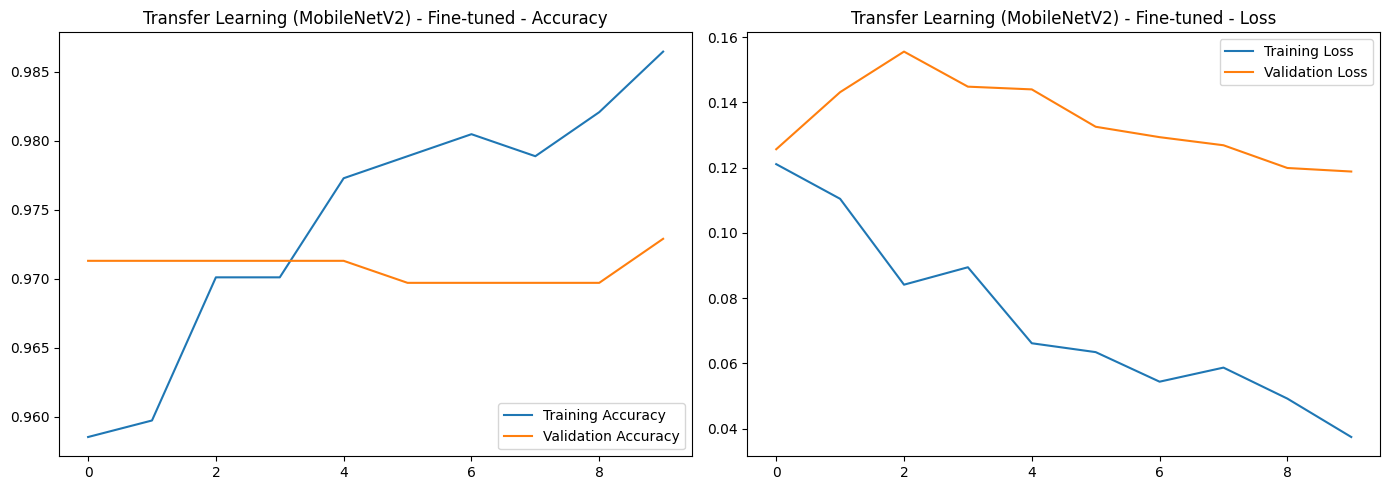

In [21]:
transfer_backbones = ['VGG16', 'ResNet50', 'MobileNetV2']
for backbone in transfer_backbones:
    print(f"\n--- Training Model: Transfer Learning with {backbone} (frozen base) ---")

    model, base = build_transfer_model(backbone, frozen=True)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=TL_LR),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    model.summary()

    history_tl = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_TL,
        callbacks=get_callbacks(f'{backbone.lower()}_frozen'),
        verbose=1
    )
    pd.DataFrame(history_tl.history).to_csv(f'artifacts/{backbone.lower()}_frozen_history.csv', index=False)
    plot_history(history_tl, f"Transfer Learning ({backbone}) - Frozen")

    # Optional: fine-tune the top layers
    if FINE_TUNE_EPOCHS > 0:
        print(f"\n--- Fine-tuning top layers of {backbone} ---")
        fine_tune_top_layers(base, trainable_ratio=0.2)  # unfreeze top 20%
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=FINE_TUNE_LR),
            loss=keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy']
        )
        history_ft = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=FINE_TUNE_EPOCHS,
            callbacks=get_callbacks(f'{backbone.lower()}_finetune'),
            verbose=1
        )
        pd.DataFrame(history_ft.history).to_csv(f'artifacts/{backbone.lower()}_finetune_history.csv', index=False)
        plot_history(history_ft, f"Transfer Learning ({backbone}) - Fine-tuned")


### Model Evaluation on Test Set

In [22]:
def evaluate_and_save(model, name):
    results = model.evaluate(test_ds, verbose=0)
    metrics = dict(zip(model.metrics_names, results))
    print(f"{name}: {metrics}")
    with open(f"artifacts/test_metrics_{name}.json", "w") as f:
        json.dump(metrics, f, indent=2)

evaluate_and_save(baseline_cnn, "baseline_cnn")
for backbone in transfer_backbones:
    # Load best frozen model checkpoint if exists for fair eval
    frozen_ckpt = os.path.join("checkpoints", f'best_{backbone.lower()}_frozen.keras')
    finetune_ckpt = os.path.join("checkpoints", f'best_{backbone.lower()}_finetune.keras')
    model_frozen, _ = build_transfer_model(backbone, frozen=True)
    model_frozen.compile(optimizer='adam',
                         loss=keras.losses.SparseCategoricalCrossentropy(),
                         metrics=['accuracy'])
    if os.path.exists(frozen_ckpt):
        model_frozen.load_weights(frozen_ckpt)
    evaluate_and_save(model_frozen, f"{backbone.lower()}_frozen")

    if os.path.exists(finetune_ckpt):
        model_ft, _ = build_transfer_model(backbone, frozen=False)  # architecture match
        model_ft.compile(optimizer='adam',
                         loss=keras.losses.SparseCategoricalCrossentropy(),
                         metrics=['accuracy'])
        model_ft.load_weights(finetune_ckpt)
        evaluate_and_save(model_ft, f"{backbone.lower()}_finetune")

baseline_cnn: {'loss': 0.6185197234153748, 'compile_metrics': 0.74643874168396}
vgg16_frozen: {'loss': 0.307353675365448, 'compile_metrics': 0.8974359035491943}
vgg16_finetune: {'loss': 0.2570807933807373, 'compile_metrics': 0.9259259104728699}
resnet50_frozen: {'loss': 0.425087571144104, 'compile_metrics': 0.9031339287757874}
resnet50_finetune: {'loss': 0.41322484612464905, 'compile_metrics': 0.9173789024353027}
mobilenetv2_frozen: {'loss': 0.1960742026567459, 'compile_metrics': 0.9373219609260559}
mobilenetv2_finetune: {'loss': 0.22298654913902283, 'compile_metrics': 0.945868968963623}


# Performance Comparison

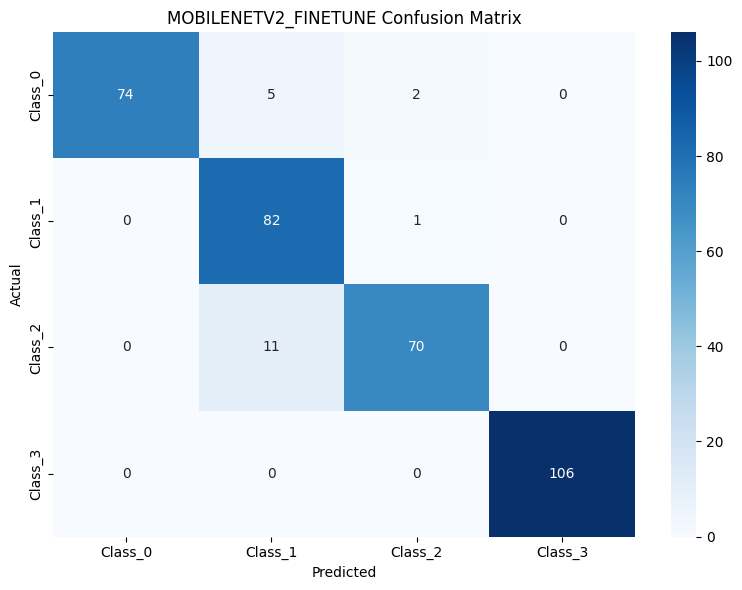


Classification Report for MOBILENETV2_FINETUNE:

              precision    recall  f1-score   support

     Class_0       1.00      0.91      0.95        81
     Class_1       0.84      0.99      0.91        83
     Class_2       0.96      0.86      0.91        81
     Class_3       1.00      1.00      1.00       106

    accuracy                           0.95       351
   macro avg       0.95      0.94      0.94       351
weighted avg       0.95      0.95      0.95       351


Model Performance Summary:

               Model  Accuracy   Loss
mobilenetv2_finetune    0.9459 0.2230
  mobilenetv2_frozen    0.9373 0.1961
      vgg16_finetune    0.9259 0.2571
   resnet50_finetune    0.9174 0.4132
     resnet50_frozen    0.9031 0.4251
        vgg16_frozen    0.8974 0.3074
        baseline_cnn    0.7464 0.6185


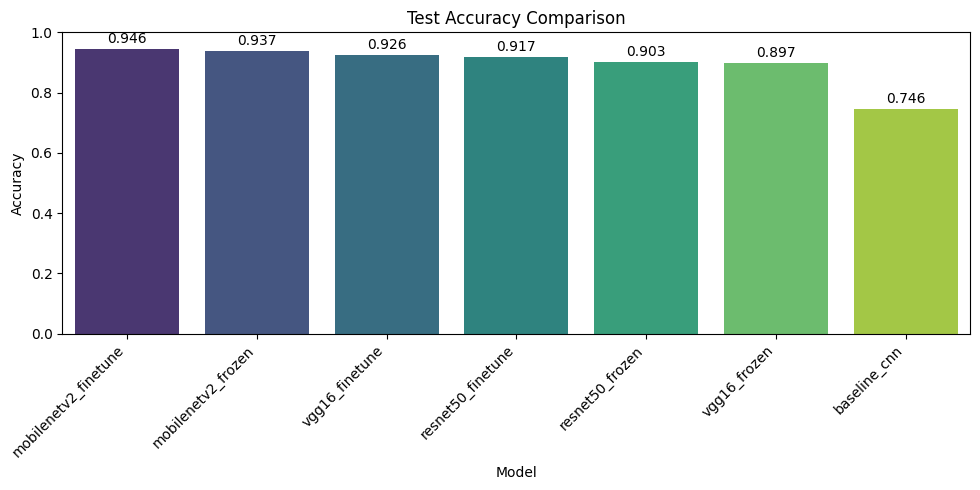

In [37]:

# Get class names
class_names = getattr(train_ds, 'class_names', None)
if class_names is None:
    y_true_all = model_performance[next(iter(model_performance))]['y_true']
    class_names = [f'Class_{i}' for i in range(len(np.unique(y_true_all)))]

# 1. Plot Confusion Matrix for Best Model
best_model_name = max(model_performance, key=lambda k: model_performance[k]['accuracy'])
y_true = model_performance[best_model_name]['y_true']
y_pred = model_performance[best_model_name]['y_pred']

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'{best_model_name.upper()} Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# 2. Print Classification Report for Best Model
report = classification_report(y_true, y_pred, target_names=class_names)
print(f"\nClassification Report for {best_model_name.upper()}:\n")
print(report)

# 3. Summary Table of All Models
summary_rows = []
for name, metrics in model_performance.items():
    summary_rows.append({
        'Model': name,
        'Accuracy': metrics['accuracy'],
        'Loss': metrics['loss']
    })

summary_df = pd.DataFrame(summary_rows).sort_values('Accuracy', ascending=False)
print("\nModel Performance Summary:\n")
print(summary_df.to_string(index=False, float_format='%.4f'))

# 4. Bar Plot Comparison of Test Accuracies
plt.figure(figsize=(10, 5))
sns.barplot(x='Model', y='Accuracy', data=summary_df, palette='viridis')
plt.title('Test Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, acc in enumerate(summary_df['Accuracy']):
    plt.text(i, acc + 0.01, f'{acc:.3f}', ha='center', va='bottom')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [30]:

def evaluate_model_on_test_set(model, model_name, test_ds):
    """Evaluate a single model and return metrics"""
    print(f"\nEvaluating {model_name.upper()}...")

    # Evaluate on test set
    results = model.evaluate(test_ds, verbose=0)
    test_loss, test_acc = results[0], results[1]

    # Get predictions
    predictions = model.predict(test_ds, verbose=0)
    y_pred = np.argmax(predictions, axis=1)

    # Get true labels from test dataset
    y_true = np.concatenate([y for x, y in test_ds], axis=0)

    # Get class names (assuming you have them defined)
    # If you don't have class_names, create generic ones
    try:
        class_names = list(train_ds.class_names)  # TensorFlow datasets have class_names
    except:
        # Fallback if class_names not available
        num_classes = len(np.unique(y_true))
        class_names = [f'Class_{i}' for i in range(num_classes)]

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name.upper()} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig(f'artifacts/cm_{model_name}.png', dpi=150)
    plt.close()  # Close to save memory

    # Generate classification report
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

    # Save classification report
    with open(f'artifacts/report_{model_name}.json', 'w') as f:
        json.dump(report, f, indent=2)

    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    return {
        'accuracy': float(test_acc),
        'loss': float(test_loss),
        'predictions': predictions,
        'y_true': y_true,
        'y_pred': y_pred
    }


In [31]:

# Dictionary to store all model performance
model_performance = {}

# Evaluate baseline CNN
print("=== EVALUATING BASELINE CNN ===")
baseline_results = evaluate_model_on_test_set(baseline_cnn, "baseline_cnn", test_ds)
model_performance["baseline_cnn"] = baseline_results

# Evaluate transfer learning models
for backbone in transfer_backbones:
    # Evaluate frozen model
    frozen_name = f"{backbone.lower()}_frozen"
    frozen_ckpt = os.path.join("checkpoints", f'best_{frozen_name}.keras')

    if os.path.exists(frozen_ckpt):
        print(f"\n=== EVALUATING {backbone} FROZEN ===")
        model_frozen, _ = build_transfer_model(backbone, frozen=True)
        model_frozen.compile(
            optimizer='adam',
            loss=keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy']
        )
        model_frozen.load_weights(frozen_ckpt)
        frozen_results = evaluate_model_on_test_set(model_frozen, frozen_name, test_ds)
        model_performance[frozen_name] = frozen_results

    # Evaluate fine-tuned model
    finetune_name = f"{backbone.lower()}_finetune"
    finetune_ckpt = os.path.join("checkpoints", f'best_{finetune_name}.keras')

    if os.path.exists(finetune_ckpt):
        print(f"\n=== EVALUATING {backbone} FINE-TUNED ===")
        model_ft, base = build_transfer_model(backbone, frozen=False)
        fine_tune_top_layers(base, trainable_ratio=0.2)  # Match training setup
        model_ft.compile(
            optimizer='adam',
            loss=keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy']
        )
        model_ft.load_weights(finetune_ckpt)
        finetune_results = evaluate_model_on_test_set(model_ft, finetune_name, test_ds)
        model_performance[finetune_name] = finetune_results

# Create performance comparison DataFrame
perf_data = []
for model_name, results in model_performance.items():
    perf_data.append({
        'Model': model_name,
        'Test Accuracy': results['accuracy'],
        'Test Loss': results['loss']
    })

perf_df = pd.DataFrame(perf_data).sort_values('Test Accuracy', ascending=False)

print('\n' + '='*50)
print('MODEL PERFORMANCE COMPARISON:')
print('='*50)
print(perf_df.to_string(index=False, float_format='%.4f'))


=== EVALUATING BASELINE CNN ===

Evaluating BASELINE_CNN...
Test Accuracy: 0.7464
Test Loss: 0.6185

=== EVALUATING VGG16 FROZEN ===

Evaluating VGG16_FROZEN...
Test Accuracy: 0.8974
Test Loss: 0.3074

=== EVALUATING VGG16 FINE-TUNED ===

Evaluating VGG16_FINETUNE...
Test Accuracy: 0.9259
Test Loss: 0.2571

=== EVALUATING ResNet50 FROZEN ===

Evaluating RESNET50_FROZEN...
Test Accuracy: 0.9031
Test Loss: 0.4251

=== EVALUATING ResNet50 FINE-TUNED ===

Evaluating RESNET50_FINETUNE...
Test Accuracy: 0.9174
Test Loss: 0.4132

=== EVALUATING MobileNetV2 FROZEN ===

Evaluating MOBILENETV2_FROZEN...
Test Accuracy: 0.9373
Test Loss: 0.1961

=== EVALUATING MobileNetV2 FINE-TUNED ===

Evaluating MOBILENETV2_FINETUNE...
Test Accuracy: 0.9459
Test Loss: 0.2230

MODEL PERFORMANCE COMPARISON:
               Model  Test Accuracy  Test Loss
mobilenetv2_finetune         0.9459     0.2230
  mobilenetv2_frozen         0.9373     0.1961
      vgg16_finetune         0.9259     0.2571
   resnet50_finetune 

In [32]:

# Save performance comparison
perf_df.to_csv('artifacts/model_comparison.csv', index=False)

# Plot model comparison
plt.figure(figsize=(12, 6))
bars = plt.bar(perf_df['Model'], perf_df['Test Accuracy'], color='skyblue', edgecolor='navy')
plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Models', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)

# Add accuracy values on top of bars
for bar, accuracy in zip(bars, perf_df['Test Accuracy']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{accuracy:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('artifacts/model_comparison.png', dpi=150, bbox_inches='tight')
plt.close()

# Find best performing model
best_model_name = perf_df.iloc[0]['Model']
best_accuracy = perf_df.iloc[0]['Test Accuracy']

print(f"\n🏆 BEST PERFORMING MODEL: {best_model_name.upper()}")
print(f"🎯 BEST TEST ACCURACY: {best_accuracy:.4f}")

# Load and save the best model
best_model_path = os.path.join("checkpoints", f'best_{best_model_name}.keras')
if os.path.exists(best_model_path):
    # Reconstruct the best model architecture
    if "baseline" in best_model_name:
        best_model = baseline_cnn
    else:
        # Parse backbone name from model name
        for backbone in transfer_backbones:
            if backbone.lower() in best_model_name:
                if "finetune" in best_model_name:
                    best_model, base = build_transfer_model(backbone, frozen=False)
                    fine_tune_top_layers(base, trainable_ratio=0.2)
                else:
                    best_model, _ = build_transfer_model(backbone, frozen=True)
                best_model.compile(
                    optimizer='adam',
                    loss=keras.losses.SparseCategoricalCrossentropy(),
                    metrics=['accuracy']
                )
                best_model.load_weights(best_model_path)
                break

    # Save best model in final location
    best_model.save(f'artifacts/best_model_{best_model_name}.keras')
    print(f"✅ Best model saved as: artifacts/best_model_{best_model_name}.keras")

# Save class indices if available
try:
    if hasattr(train_ds, 'class_names'):
        class_indices = {name: idx for idx, name in enumerate(train_ds.class_names)}
        with open('artifacts/class_indices.json', 'w') as f:
            json.dump(class_indices, f, indent=2)
        print("✅ Class indices saved to artifacts/class_indices.json")
except:
    print("⚠️  Could not save class indices - not available in dataset")

print(f"\n📊 All evaluation artifacts saved to 'artifacts/' directory")



🏆 BEST PERFORMING MODEL: MOBILENETV2_FINETUNE
🎯 BEST TEST ACCURACY: 0.9459
✅ Best model saved as: artifacts/best_model_mobilenetv2_finetune.keras

📊 All evaluation artifacts saved to 'artifacts/' directory
